# **Homework 3 - Convolutional Neural Network**

若有任何问题，欢迎来信至助教信箱 ntu-ml-2020spring-ta@googlegroups.com

In [31]:
!gdown --id '19CzXudqN58R3D-1G8KeFWk8UDQwlb8is' --output food-11.zip # 下载数据集
!unzip food-11.zip # 解压缩

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: food-11/training/8_427.jpg  
  inflating: food-11/training/2_849.jpg  
  inflating: food-11/training/4_165.jpg  
  inflating: food-11/training/5_376.jpg  
  inflating: food-11/training/2_691.jpg  
  inflating: food-11/training/0_541.jpg  
  inflating: food-11/training/3_482.jpg  
  inflating: food-11/training/0_227.jpg  
  inflating: food-11/training/5_410.jpg  
  inflating: food-11/training/4_603.jpg  
  inflating: food-11/training/8_341.jpg  
  inflating: food-11/training/5_1154.jpg  
  inflating: food-11/training/9_37.jpg  
  inflating: food-11/training/9_152.jpg  
  inflating: food-11/training/5_438.jpg  
  inflating: food-11/training/9_1287.jpg  
  inflating: food-11/training/8_369.jpg  
  inflating: food-11/training/2_1455.jpg  
  inflating: food-11/training/10_247.jpg  
  inflating: food-11/training/7_32.jpg  
  inflating: food-11/training/10_521.jpg  
  inflating: food-11/training/2_1333.jpg  
  inflating: food-11/training/2_861.jpg  
  i

In [80]:
# Import需要的套件
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import time

#Read image
利用 OpenCV (cv2) 读入照片并存放在 numpy array 中

In [81]:
def readfile(path, label):
    # label 是一个 boolean variable，代表需不需要回传 y 值
    image_dir = sorted(os.listdir(path))
    x = np.zeros((len(image_dir), 128, 128, 3), dtype=np.uint8)
    # 因为是图片，所以这里设为uint8
    y = np.zeros((len(image_dir)), dtype=np.uint8)
    # cv2.imread()返回多维数组，前两维表示像素，后一维表示通道数
    for i, file in enumerate(image_dir):    # 遍历每一张图片
        img = cv2.imread(os.path.join(path, file))
        # cv2.imread()返回多维数组，前两维表示像素，后一维表示通道数
        x[i, :, :] = cv2.resize(img,(128, 128))
        # 因为每张图片的大小不一样，所以先统一大小，每张图片的大小为（128，128，3）
        if label:
          y[i] = int(file.split("_")[0])
    if label:
      return x, y
    else:
      return x

In [82]:
# 分别将 training set、validation set、testing set 用 readfile 函式读进来
workspace_dir = './food-11'
print("Reading data")
train_x, train_y = readfile(os.path.join(workspace_dir, "training"), True)
print("Size of training data = {}".format(len(train_x)))
val_x, val_y = readfile(os.path.join(workspace_dir, "validation"), True)
print("Size of validation data = {}".format(len(val_x)))
test_x = readfile(os.path.join(workspace_dir, "testing"), False)
print("Size of Testing data = {}".format(len(test_x)))

Reading data
Size of training data = 9866
Size of validation data = 3430
Size of Testing data = 3347


# Dataset
在 PyTorch 中，我们可以利用 torch.utils.data 的 Dataset 及 DataLoader 来"包装" data，使后续的 training 及 testing 更为方便。

Dataset 需要 overload 两个函数：\_\_len\_\_ 及 \_\_getitem\_\_

\_\_len\_\_ 必须要回传 dataset 的大小，而 \_\_getitem\_\_ 则定义了当程序利用 [ ] 取值时，dataset 应该要怎么回传数据。

实际上我们并不会直接使用到这两个函数，但是使用 DataLoader 在 enumerate Dataset 时会使用到，没有实做的话会在程序运行阶段出现 error。


In [83]:
# training 时做 data augmentation
train_transform = transforms.Compose([
    transforms.ToPILImage(),    # 将数据转换为PILImage
    transforms.RandomHorizontalFlip(), # 随机将图片水平翻转
    transforms.RandomRotation(15), # 随机旋转图片
    transforms.ToTensor(), # 将图片转成 Tensor，并把数值 normalize 到 [0,1] (data normalization)
    # 将PILImage或numpy.ndarray类型的数据转化为`torch.FloatTensor`类型，并且自动将数据归一化到[0, 1]区间
])
# testing 时不需做 data augmentation
test_transform = transforms.Compose([
    transforms.ToPILImage(),                                    
    transforms.ToTensor(),
])
class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        # label is required to be a LongTensor
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y)
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X

In [84]:
batch_size = 128
train_set = ImgDataset(train_x, train_y, train_transform)
val_set = ImgDataset(val_x, val_y, test_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

print("Size of validation data = {}".format(len(train_set)))
print("Size of training data = {}".format(len(val_set)))


Size of validation data = 9866
Size of training data = 3430


# Model

In [85]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()  # 需要调用module的构造函数
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 维度 [3, 128, 128]
        self.cnn = nn.Sequential(   # 模型会依次执行Sequential中的函数
            nn.Conv2d(3, 64, 3, 1, 1),  # output:[64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

# Training

使用 training set 训练，并使用 validation set 寻找好的参数

In [86]:
model = Classifier().cuda()
loss = nn.CrossEntropyLoss() # 因为是 classification task，所以 loss 使用 CrossEntropyLoss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # optimizer 使用 Adam
num_epoch = 30

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    model.train() # 确保 model 是在 train model (开启 Dropout 等...)
    #model.train()是保证BN层用每一批数据的均值和方差，而model.eval()是保证BN用全部训练数据的均值和方差；
    #而对于Dropout，model.train()是随机取一部分网络连接来训练更新参数，而model.eval()是利用到了所有网络连接。

    for i, data in enumerate(train_loader):
        optimizer.zero_grad() # 用 optimizer 将 model 参数的 gradient 归零
        train_pred = model(data[0].cuda()) # 利用 model 得到预测的机率分布 这边实际上就是去呼叫 model 的 forward 函数
        batch_loss = loss(train_pred, data[1].cuda()) # 计算 loss （注意 prediction 跟 label 必须同时在 CPU 或是 GPU 上）
        batch_loss.backward() # 利用 back propagation 算出每个参数的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新参数值
        # train_pred是(128，11)的数据，np.argmax()，axis=1返回每一行最大值的索引，返回的索引正好就对应了标签，然后和y真实标签比较，则可得到分类正确的数量
        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()
    
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            val_pred = model(data[0].cuda())
            batch_loss = loss(val_pred, data[1].cuda())

            val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            val_loss += batch_loss.item()

        #将结果 print 出来
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, num_epoch, time.time()-epoch_start_time, \
             train_acc/train_set.__len__(), train_loss/train_set.__len__(), val_acc/val_set.__len__(), val_loss/val_set.__len__()))
        
    for i, data in enumerate(train_loader):
        train_pred = model(data[0].cuda()) # 利用 model 得到预测的机率分布 这边实际上就是去呼叫 model 的 forward 函数
        cm_pred = []
        cm_true = []
        for pred in np.argmax(train_pred.cpu().data.numpy(), axis=1):
            cm_pred.append(pred)
        for true in data[1].numpy():
            cm_true.append(true)
        break 

[001/030] 24.10 sec(s) Train Acc: 0.254206 Loss: 0.017623 | Val Acc: 0.280466 loss: 0.015975
[002/030] 24.15 sec(s) Train Acc: 0.357896 Loss: 0.014429 | Val Acc: 0.356560 loss: 0.014794
[003/030] 23.88 sec(s) Train Acc: 0.407764 Loss: 0.013292 | Val Acc: 0.306414 loss: 0.016446
[004/030] 23.86 sec(s) Train Acc: 0.444354 Loss: 0.012569 | Val Acc: 0.359475 loss: 0.015804
[005/030] 24.02 sec(s) Train Acc: 0.479931 Loss: 0.011802 | Val Acc: 0.411079 loss: 0.013944
[006/030] 24.00 sec(s) Train Acc: 0.515913 Loss: 0.010909 | Val Acc: 0.378717 loss: 0.016931
[007/030] 23.84 sec(s) Train Acc: 0.529394 Loss: 0.010740 | Val Acc: 0.333528 loss: 0.019099
[008/030] 23.92 sec(s) Train Acc: 0.563248 Loss: 0.010001 | Val Acc: 0.531195 loss: 0.010864
[009/030] 23.96 sec(s) Train Acc: 0.576627 Loss: 0.009594 | Val Acc: 0.537026 loss: 0.010967
[010/030] 23.90 sec(s) Train Acc: 0.605514 Loss: 0.008931 | Val Acc: 0.525656 loss: 0.011236
[011/030] 23.93 sec(s) Train Acc: 0.625988 Loss: 0.008506 | Val Acc: 0

得到好的参数后，我们使用 training set 和 validation set 共同训练（数据量变多，模型效果较好）

In [79]:
train_val_x = np.concatenate((train_x, val_x), axis=0)
train_val_y = np.concatenate((train_y, val_y), axis=0)
train_val_set = ImgDataset(train_val_x, train_val_y, train_transform)
train_val_loader = DataLoader(train_val_set, batch_size=batch_size, shuffle=True)

print(len(train_val_set))

13296


In [58]:
model_best = Classifier().cuda()
loss = nn.CrossEntropyLoss() # 因为是 classification task，所以 loss 使用 CrossEntropyLoss
optimizer = torch.optim.Adam(model_best.parameters(), lr=0.001) # optimizer 使用 Adam
num_epoch = 30

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0

    model_best.train()
    for i, data in enumerate(train_val_loader):
        optimizer.zero_grad()
        train_pred = model_best(data[0].cuda())
        batch_loss = loss(train_pred, data[1].cuda())
        batch_loss.backward()
        optimizer.step()
        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()

        #将结果 print 出来
    print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f' % \
      (epoch + 1, num_epoch, time.time()-epoch_start_time, \
      train_acc/train_val_set.__len__(), train_loss/train_val_set.__len__()))

[001/001] 28.55 sec(s) Train Acc: 0.232476 Loss: 0.017742


# Testing
利用刚刚 train 好的 model 进行 prediction

In [76]:
test_set = ImgDataset(test_x, transform=test_transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
print("Size of testing data = {}".format(len(test_set)))

Size of testing data = 3347


In [ ]:
model_best.eval()
prediction = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        test_pred = model_best(data.cuda())
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        for y in test_label:
            prediction.append(y)

In [ ]:
#将结果写入 csv 檔
with open("predict.csv", 'w') as f:
    f.write('Id,Category\n')
    for i, y in  enumerate(prediction):
        f.write('{},{}\n'.format(i, y))

128 128


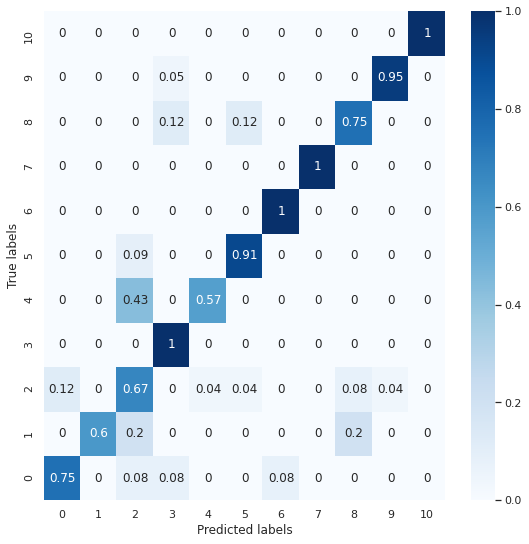

In [87]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
C2=confusion_matrix(cm_true, cm_pred, labels=[0,1,2,3,4,5,6,7,8,9,10])


print(len(cm_true),len(cm_pred))


con_mat_norm = C2.astype('float') / C2.sum(axis=1)[:, np.newaxis]     # 归一化
con_mat_norm = np.around(con_mat_norm, decimals=2)
plt.figure(figsize=(9, 9))
sns.heatmap(con_mat_norm, annot=True, cmap='Blues')
plt.ylim(0, 11)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# 0Bread, 1Dairy product, 2Dessert, 3Egg, 4Fried food, 5Meat, 6Noodles/Pasta, 7Rice, 8Seafood, 9Soup, 10Vegetable/Fruit.

# 识别率低的有 1 2 4 8
# 2和4容易混淆